In [1]:
%matplotlib inline

# StackingCVClassifier

An ensemble-learning meta-classifier for stacking using cross-validation to prepare the inputs for the level-2 classifier to prevent overfitting.

> from mlxtend.classifier import StackingCVClassifier

# Overview

Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. The `StackingCVClassifier` extends the standard stacking algorithm (implemented as [`StackingClassifier`](StackingClassifier.md)) using cross-validation to prepare the input data for the level-2 classifier. 

In the standard stacking procedure, the first-level classifiers are fit to the same training set that is used prepare the inputs for the second-level classifier, which may lead to overfitting. The `StackingCVClassifier`, however, uses the concept of cross-validation: the dataset is split into *k* folds, and in *k* successive rounds, *k-1* folds are used to fit the first level classifier; in each round, the first-level classifiers are then applied to the remaining 1 subset that was not used for model fitting in each iteration. The resulting predictions are then stacked and provided -- as input data -- to the second-level classifier. After the training of the `StackingCVClassifier`, the first-level classifiers are fit to the entire dataset as illustrated in the figure below.

![](./StackingCVClassifier_files/stacking_cv_classification_overview.png)

More formally, the Stacking Cross-Validation algorithm can be summarized as follows (source: [1]):
    
![](./StackingCVClassifier_files/stacking_cv_algorithm.png)

### References


- [1] Tang, J., S. Alelyani, and H. Liu. "[Data Classification: Algorithms and Applications.](https://books.google.com/books?id=nwQZCwAAQBAJ&lpg=PA500&dq=stacking%20classifier%20subsets&pg=PA499#v=onepage&q&f=false)" Data Mining and Knowledge Discovery Series, CRC Press (2015): pp. 498-500.
- [2] Wolpert, David H. "[Stacked generalization.](http://www.sciencedirect.com/science/article/pii/S0893608005800231)" Neural networks 5.2 (1992): 241-259.

# Examples

## Example 1 - Simple Stacking CV Classification

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [3]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
import numpy as np

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=42)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], 
                            meta_classifier=lr,
                            random_state=42)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_validation.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

/Users/Sebastian/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.90 (+/- 0.03) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.93 (+/- 0.02) [StackingClassifier]


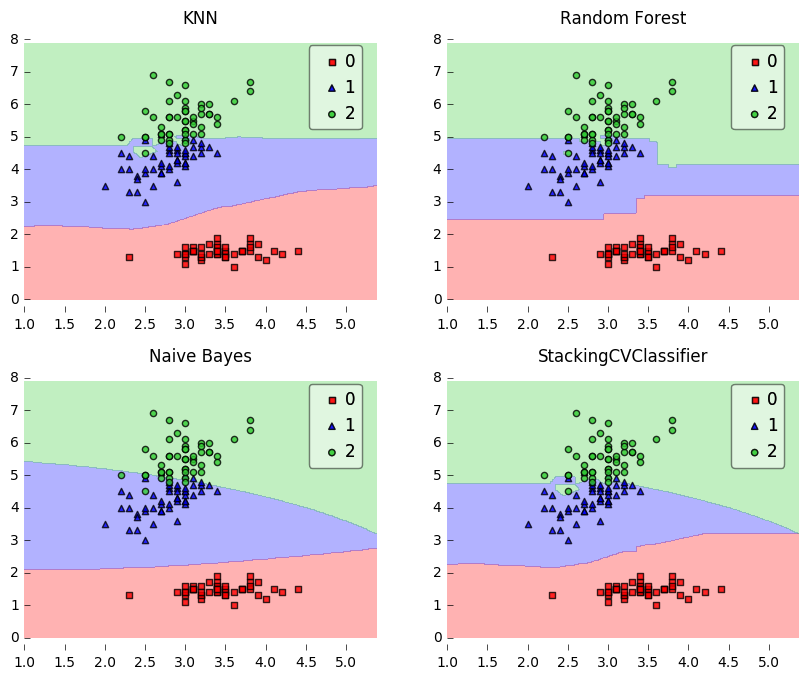

In [4]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingCVClassifier'],
                          itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()

## Example 2 - Using Probabilities as Meta-Features

Alternatively, the class-probabilities of the first-level classifiers can be used to train the meta-classifier (2nd-level classifier) by setting `use_probas=True`. For example, in a 3-class setting with 2 level-1 classifiers, these classifiers may make the following "probability" predictions for 1 training sample:

- classifier 1: [0.2, 0.5, 0.3]
- classifier 2: [0.3, 0.4, 0.4]

This results in *k* features, where *k* = [n_classes * n_classifiers], by stacking these level-1 probabilities:

- [0.2, 0.5, 0.3, 0.3, 0.4, 0.4]


In [5]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            use_probas=True,
                            meta_classifier=lr,
                            random_state=42)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_validation.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.91 (+/- 0.06) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.94 (+/- 0.03) [StackingClassifier]


## Example 3 - Stacked CV Classification and GridSearch

To set up a parameter grid for scikit-learn's `GridSearch`, we simply provide the estimator's names in the parameter grid -- in the special case of the meta-regressor, we append the `'meta-'` prefix.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=42)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], 
                            meta_classifier=lr,
                            random_state=42)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta-logisticregression__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() / 2.0, params))

/Users/Sebastian/miniconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.667 (+/-0.000) for {'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier__n_neighbors': 1}
0.667 (+/-0.000) for {'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 50, 'kneighborsclassifier__n_neighbors': 1}
0.940 (+/-0.024) for {'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier__n_neighbors': 1}
0.927 (+/-0.024) for {'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 50, 'kneighborsclassifier__n_neighbors': 1}
0.667 (+/-0.000) for {'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier__n_neighbors': 5}
0.667 (+/-0.000) for {'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 50, 'kneighborsclassifier__n_neighbors': 5}
0.933 (+/-0.028) for {'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier__n_neighbors': 5}
0.933 (+/-

In case we are planning to use a regression algorithm multiple times, all we need to do is to add an additional number suffix in the parameter grid as shown below:

In [7]:
from sklearn.grid_search import GridSearchCV

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingCVClassifier(classifiers=[clf1, clf1, clf2, clf3], 
                            meta_classifier=lr,
                            random_state=42)

params = {'kneighborsclassifier-1__n_neighbors': [1, 5],
          'kneighborsclassifier-2__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta-logisticregression__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() / 2, params))

0.667 (+/-0.000) for {'meta-logisticregression__C': 0.1, 'kneighborsclassifier-1__n_neighbors': 1, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier-2__n_neighbors': 1}
0.667 (+/-0.000) for {'meta-logisticregression__C': 0.1, 'kneighborsclassifier-1__n_neighbors': 1, 'randomforestclassifier__n_estimators': 50, 'kneighborsclassifier-2__n_neighbors': 1}
0.927 (+/-0.031) for {'meta-logisticregression__C': 10.0, 'kneighborsclassifier-1__n_neighbors': 1, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier-2__n_neighbors': 1}
0.933 (+/-0.028) for {'meta-logisticregression__C': 10.0, 'kneighborsclassifier-1__n_neighbors': 1, 'randomforestclassifier__n_estimators': 50, 'kneighborsclassifier-2__n_neighbors': 1}
0.667 (+/-0.000) for {'meta-logisticregression__C': 0.1, 'kneighborsclassifier-1__n_neighbors': 1, 'randomforestclassifier__n_estimators': 10, 'kneighborsclassifier-2__n_neighbors': 5}
0.667 (+/-0.000) for {'meta-logisticregression__C': 0.1, 'kneighborsclass

# API

In [8]:
with open('../../api_modules/mlxtend.classifier/StackingCVClassifier.md', 'r') as f:
    print(f.read())

## StackingCVClassifier

*StackingCVClassifier(classifiers, meta_classifier, use_probas=False, n_folds=2, use_features_in_secondary=False, stratify=True, random_state=None, shuffle=True, verbose=0)*

A 'Stacking Cross-Validation' classifier for scikit-learn estimators.

New in mlxtend v0.4.3

**Parameters**

- `classifiers` : array-like, shape = [n_classifiers]

    A list of classifiers.
    Invoking the `fit` method on the `StackingClassifer` will fit clones
    of these original classifiers that will
    be stored in the class attribute
    `self.clfs_`.

- `meta_classifier` : object

    The meta-classifier to be fitted on the ensemble of
    classifiers

- `use_probas` : bool (default: False)

    If True, trains meta-classifier based on predicted probabilities
    instead of class labels.

- `n_folds` : int (default=2)

    The number of folds used for while creating training data for the
    meta-classifier during fitting.

- `use_features_in_secondary` : bool (default: False)

